# Gene Ontology generic slim

In [1]:
from ontobio.ontol_factory import OntologyFactory
ont = OntologyFactory().create("go")
slim = OntologyFactory().create("goslim_generic.json")

MOLECULAR_FUNCTION = "GO:0003674"

slim_go_terms = [el for el in list(slim.get_graph().nodes()) if el.startswith("GO")] # get all GO terms in generic slim set
molecular_functions = ont.descendants(MOLECULAR_FUNCTION) # get all molecular functions in GO
slim_molecular_functions = list(set(slim_go_terms) & set(molecular_functions)) # take intersetcion between molecular functions and slim GO terms
slim_molecular_functions_descendants = {el : set(ont.descendants(el)) for el in slim_molecular_functions} # get all descendants of the above

In [2]:
import pandas as pd
import torch
import numpy as np

# this is a customized version of the UniProt database, only for human proteins, which are around 20k
# the columns were chosen to minimize the size of the file while maintaining useful information
df = pd.read_csv("uniprotkb_reviewed_true_AND_model_organ_2023_12_29.tsv", sep="\t")
df = df[~df['Gene Ontology (GO)'].isna()] # remove the ones without GO annotations

In [3]:
df = df[~df['Gene Ontology (molecular function)'].isna()] # remove the ones without GO annotations
df.head()

,Entry,Entry Name,Protein names,Gene Names,Organism,Length,Sequence,Gene Ontology (molecular function),Gene Ontology (cellular component),Gene Ontology (biological process),Gene Ontology IDs,Gene Ontology (GO)
1,A0A024RBG1,NUD4B_HUMAN,Diphosphoinositol polyphosphate phosphohydrola...,NUDT4B,Homo sapiens (Human),181,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,bis(5'-adenosyl)-hexaphosphatase activity [GO:...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,adenosine 5'-(hexahydrogen pentaphosphate) cat...,GO:0000298; GO:0003723; GO:0005634; GO:0005737...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...
28,A0A075B6Q5,HV364_HUMAN,Immunoglobulin heavy variable 3-64,IGHV3-64,Homo sapiens (Human),118,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
30,A0A075B6R2,HV404_HUMAN,Immunoglobulin heavy variable 4-4,IGHV4-4,Homo sapiens (Human),117,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,antigen binding [GO:0003823],extracellular region [GO:0005576]; immunoglobu...,immunoglobulin mediated immune response [GO:00...,GO:0003823; GO:0005576; GO:0005886; GO:0016064...,extracellular region [GO:0005576]; immunoglobu...
38,A0A075B6T6,TVAL2_HUMAN,T cell receptor alpha variable 12-2,TRAV12-2,Homo sapiens (Human),113,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...
43,A0A075B6W5,TVA23_HUMAN,T cell receptor alpha variable 23/delta variab...,TRAV23DV6,Homo sapiens (Human),121,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,peptide antigen binding [GO:0042605],T cell receptor complex [GO:0042101],adaptive immune response [GO:0002250],GO:0002250; GO:0042101; GO:0042605,T cell receptor complex [GO:0042101]; peptide ...


<AxesSubplot:>

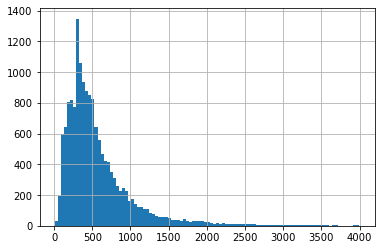

In [4]:
df[df['Length'] < 4000]['Length'].hist(bins=100)

In [5]:
df['Gene Ontology (molecular function)'] = df['Gene Ontology (molecular function)']\
    .apply(lambda x: x.split(";")).apply(lambda x: [el[el.index("[GO")+1:-1] for el in x])

In [6]:
for k in slim_molecular_functions:
    df[ont.node(k)['label']] = df['Gene Ontology (molecular function)']\
        .apply(lambda x: max([True if el in slim_molecular_functions_descendants[k] else False for el in x]))

In [7]:
ohe_df = df.drop(columns=['Entry', 'Entry Name', 'Protein names', 'Gene Names', 'Organism',
                            'Length', 'Gene Ontology (molecular function)',
                            'Gene Ontology (cellular component)',
                            'Gene Ontology (biological process)', 'Gene Ontology IDs',
                            'Gene Ontology (GO)'])
ohe_df.head()

,Sequence,ligase activity,molecular transducer activity,lipid binding,ATP-dependent activity,oxidoreductase activity,"catalytic activity, acting on RNA",DNA binding,transcription regulator activity,cargo receptor activity,...,cyclase activity,molecular adaptor activity,histone binding,isomerase activity,translation regulator activity,general transcription initiation factor activity,structural molecule activity,"catalytic activity, acting on DNA",cytoskeletal motor activity,cell adhesion mediator activity
1,MMKFKPNQTRTYDREGFKKRAACLCFRSEQEDEVLLVSSSRYPDQW...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
28,MMEFGLSWVFLVAIFKGVQCEVQLVESGEGLVQPGGSLRLSCAASG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
30,MKHLWFFLLLVAAPRWVLSQVQLQESGPGLVKPSGTLSLTCAVSGG...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
38,MKSLRVLLVILWLQLSWVWSQQKEVEQNSGPLSVPEGAIASLNCTY...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
43,MDKILGASFLVLWLQLCWVSGQQKEKSDQQQVKQSPQSLIVQKGGI...,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [8]:
labels = ohe_df.drop(columns=["Sequence"]).columns
X = df[labels].to_numpy().astype(np.float32)
l = []
for i in range(X.shape[0]):
    l.append(torch.tensor(X[i,:]))

# LLM Fine Tuning (using a Logistic Regression as Classification Head)
This way we take advantage of Logistic Regression multivariate response and perform independent classification of all the various classes

In [9]:
from datasets import Dataset

ds = Dataset.from_dict({"labels": l, "sequence" : df['Sequence']})
ds = ds.shuffle(seed=42).train_test_split(test_size=0.2)
ds

DatasetDict({
    train: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 3205
    })
})

In [10]:
def from_list_to_tensor(mapped_ds):
    mapped_ds['labels'] = torch.tensor(mapped_ds['labels'])
    return

ds = ds.map(from_list_to_tensor)
ds

Map:   0%|          | 0/12817 [00:00<?, ? examples/s]

Map:   0%|          | 0/3205 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'sequence'],
        num_rows: 3205
    })
})

In [11]:
type(ds['train'][0]['labels'])

list

In [12]:
from transformers import AutoTokenizer, EsmModel
import torch
import os

os.environ['TOKENIZERS_PARALLELISM'] = "false"
os.environ["WANDB_DISABLED"] = "true"

#checkpoint = "facebook/esm2_t30_150M_UR50D"
#checkpoint = "facebook/esm2_t12_35M_UR50D"
checkpoint = "facebook/esm2_t6_8M_UR50D"

BATCH_SIZE = 4
NUM_EPOCHS = 4

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = EsmModel.from_pretrained(checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def preprocess_tokenize(mapped_ds):
    return tokenizer(mapped_ds['sequence'], truncation=True, max_length=1024)

ds = ds.map(preprocess_tokenize)
ds = ds.remove_columns("sequence")
ds

Map:   0%|          | 0/12817 [00:00<?, ? examples/s]

Map:   0%|          | 0/3205 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 12817
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 3205
    })
})

In [109]:
#import pytorch_lightning as pl
import torch.nn as nn
from transformers import Trainer, TrainingArguments

class ESMwithMultiClass(nn.Module):
    def __init__(self, num_labels=40, lr=1e-4):
        super().__init__()
        self.llm = model
        self.num_labels = num_labels
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(in_features=model.pooler.dense.in_features, out_features=self.num_labels),
            nn.Sigmoid()
        )
        self.lr = lr

    def forward(self, input_ids, attention_mask, labels=None):
        return {'logits': self.clf(self.llm(input_ids, attention_mask).pooler_output)}
    
class MultilabelTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        print(labels)
        logits = model(**inputs)['logits']
        #logits = outputs.get('logits')
        print(logits.shape, labels.shape)
        loss_fct = nn.BCELoss()
        loss = loss_fct(logits.view(-1, self.model.num_labels),
                        labels.float().view(-1, self.model.num_labels))
        loss = loss.mean()
        return (loss, logits) if return_outputs else loss

In [110]:
import evaluate
from transformers import DataCollatorWithPadding
from typing import List, Dict, Any

def compute_metrics(eval_pred):
    f1_score = evaluate.load("f1")
    predictions, labels = eval_pred
    print(predictions, labels)
    print(eval_pred.inputs)
    predictions = np.where(predictions > 0.5, 1, 0)
    return f1_score.compute(predictions=predictions, references=labels, average="macro")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [111]:
esm = ESMwithMultiClass()
training_args = TrainingArguments(
    output_dir="./esm_multilabel",
    learning_rate=1e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    logging_steps=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [112]:
trainer = MultilabelTrainer( # can you belive that it drops columns that are not explicitly used by the model?
        model=esm,
        args=training_args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

In [113]:
esm(input_ids=torch.tensor(ds['train'][0]['input_ids']).reshape(1, -1).cuda(),\
     attention_mask=torch.tensor(ds['train'][0]['attention_mask']).reshape(1, -1).cuda())

{'logits': tensor([[0.4908, 0.4881, 0.4697, 0.5397, 0.5295, 0.4676, 0.5231, 0.5046, 0.5487,
          0.4875, 0.4748, 0.5492, 0.4849, 0.4910, 0.5185, 0.5535, 0.5199, 0.4618,
          0.4615, 0.5193, 0.4672, 0.5108, 0.5092, 0.4809, 0.5191, 0.4646, 0.4903,
          0.5194, 0.5384, 0.4960, 0.4594, 0.4878, 0.4776, 0.4460, 0.5172, 0.5490,
          0.4813, 0.4997, 0.4882, 0.4867]], device='cuda:0',
        grad_fn=<SigmoidBackward0>)}

In [117]:
trainer.compute_loss(esm, inputs={'input_ids' : torch.tensor(ds['train'][0]['input_ids']).reshape(1, -1).cuda(), \
                                  'attention_mask' : torch.tensor(ds['train'][0]['attention_mask']).reshape(1, -1).cuda(),\
                                    'labels' : torch.tensor(ds['train'][0]['labels']).reshape(1, -1).cuda()})

AttributeError: 'NoneType' object has no attribute 'shape'

In [114]:
print(ds['train'][0]['labels'])

[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [115]:
trainer.evaluate(ds['train'].select(range(4)))

torch.Size([4, 40]) torch.Size([4, 40])


[[0.49389088 0.49473122 0.5023943  0.54232216 0.51024204 0.48709422
  0.50242937 0.49833402 0.52483505 0.48378438 0.48688793 0.5326821
  0.48892194 0.49770436 0.53478795 0.51455873 0.5240493  0.45765314
  0.44138598 0.51221174 0.47918987 0.52016085 0.53126955 0.51313734
  0.51786894 0.48683336 0.49343672 0.5060582  0.5345059  0.50766534
  0.4725529  0.4942415  0.48156124 0.45187175 0.49797878 0.5390154
  0.48503262 0.51738364 0.49831507 0.5068309 ]
 [0.47433588 0.49485624 0.51212513 0.54463464 0.515544   0.4529847
  0.509742   0.48299694 0.51259345 0.5011304  0.4781159  0.5320843
  0.46930498 0.512989   0.5125649  0.5165732  0.51582146 0.4542766
  0.4752437  0.51129895 0.4673905  0.52727747 0.5222135  0.5052508
  0.5166924  0.47715938 0.49944678 0.49581954 0.5354179  0.49035886
  0.48950922 0.47653058 0.47153872 0.45467803 0.5005267  0.5227181
  0.489866   0.50261545 0.49001724 0.496993  ]
 [0.5000243  0.4899014  0.49508667 0.5426194  0.51251304 0.49180743
  0.49636418 0.49591625 0.523

ValueError: Mismatch in the number of predictions (3) and references (4)